## Week 3: Exploring Overfitting in NLP

Sentiment140 dataset
* 1.6 million tweets
* sentiment (0 for negative and 4 for positive)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import csv
import re
import string
import random

from scipy.stats import linregress
from tensorflow.keras import layers, losses

In [2]:
EMBEDDING_DIM = 100
SEQUENCE_LENGTH = 16
OOV_TOKEN = '[UNK]'
MAX_EXAMPLES = 160000
TRAINING_SPLIT = .9

In [3]:
dataset_path = '../../../data/training_cleaned.csv'

In [4]:
def parse_data_from_file(filename):

    sentences = []
    labels = []

    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile)

        for row in reader:
            sentences.append(row[5])
            labels.append([0] if int(row[0]) == 0 else [1])

    return sentences, labels

In [5]:
sentences, labels = parse_data_from_file(dataset_path)

In [6]:
total_tweets = len(sentences)
random.seed(42)
selected_tweets = random.sample(range(total_tweets), MAX_EXAMPLES)
sentences = [sentences[i] for i in selected_tweets]
labels = [labels[i] for i in selected_tweets]


In [7]:
def train_val_split(sentences, labels, training_split):

    train_size = int(len(sentences) * training_split)

    train_sentences = sentences[:train_size]
    y_train = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    return train_sentences, validation_sentences, y_train, validation_labels

In [8]:
train_sentences, val_sentences, y_train, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

In [9]:
print(f"{len(train_sentences)} sentences for training.")
print(f"{len(val_sentences)} sentences for validation.")

144000 sentences for training.
16000 sentences for validation.


In [10]:
def custom_standardization(input_data):
    
    text = tf.strings.lower(input_data, encoding='utf-8')
    
    # filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    text = tf.strings.regex_replace(text, '[%s]' % re.escape(string.punctuation), ' ')

    return text

In [11]:
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    output_sequence_length=SEQUENCE_LENGTH)

vectorize_layer.adapt(train_sentences)

VOCAB_SIZE = len(vectorize_layer.get_vocabulary())

In [12]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [13]:
raw_train_ds = tf.data.Dataset.from_tensor_slices((train_sentences, y_train))
raw_val_ds = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels))

batch_size = 256

raw_train_ds = raw_train_ds.batch(batch_size)
raw_val_ds = raw_val_ds.batch(batch_size)

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

In [14]:
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

### Using pre-defined Embeddings

In [15]:
path_to_glove_file  = '../../../data/glove.6B.100d.txt'

embeddings_index = {}

with open(path_to_glove_file ) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [16]:
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for i, word in enumerate(vectorize_layer.get_vocabulary()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [17]:
def create_model(vocab_size, embedding_dim, sequence_length, embeddings_matrix):
    
    lstm_dim = 32
    dense_dim = 6

    model = tf.keras.Sequential([ 
        layers.Embedding(vocab_size, embedding_dim, input_length=sequence_length, weights=[embeddings_matrix], trainable=False),
        layers.Dropout(0.2),
        layers.Bidirectional(layers.LSTM(lstm_dim)),
        layers.Dropout(0.2),
        layers.Dense(dense_dim, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(optimizer='adam',
                  loss=losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy']) 

    return model

In [18]:
model = create_model(VOCAB_SIZE, EMBEDDING_DIM, SEQUENCE_LENGTH, embedding_matrix)

history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
563/563 [==============================] - 13s 15ms/step - loss: 0.5827 - accuracy: 0.6637 - val_loss: 0.5333 - val_accuracy: 0.7381
Epoch 2/20
563/563 [==============================] - 7s 13ms/step - loss: 0.5325 - accuracy: 0.7122 - val_loss: 0.5171 - val_accuracy: 0.7506
Epoch 3/20
563/563 [==============================] - 7s 13ms/step - loss: 0.5173 - accuracy: 0.7248 - val_loss: 0.5001 - val_accuracy: 0.7546
Epoch 4/20
563/563 [==============================] - 7s 13ms/step - loss: 0.5062 - accuracy: 0.7328 - val_loss: 0.5020 - val_accuracy: 0.7622
Epoch 5/20
563/563 [==============================] - 7s 13ms/step - loss: 0.4978 - accuracy: 0.7391 - val_loss: 0.4884 - val_accuracy: 0.7619
Epoch 6/20
563/563 [==============================] - 7s 13ms/step - loss: 0.4930 - accuracy: 0.7430 - val_loss: 0.4923 - val_accuracy: 0.7646
Epoch 7/20
563/563 [==============================] - 7s 13ms/step - loss: 0.4860 - accuracy: 0.7473 - val_loss: 0.4891 - val_accuracy: 0.767

Notes

```python
    lstm_dim = 32
    dense_dim = 6

    model = tf.keras.Sequential([ 
        ...
        layers.Dropout(0.2),
        layers.Bidirectional(layers.LSTM(lstm_dim)),
        layers.Dropout(0.2),
        layers.Dense(dense_dim, activation='relu'),
        layers.Dense(1)
    ])
```
loss: 0.4602 - accuracy: 0.7667 - val_loss: 0.4707 - val_accuracy: 0.7747

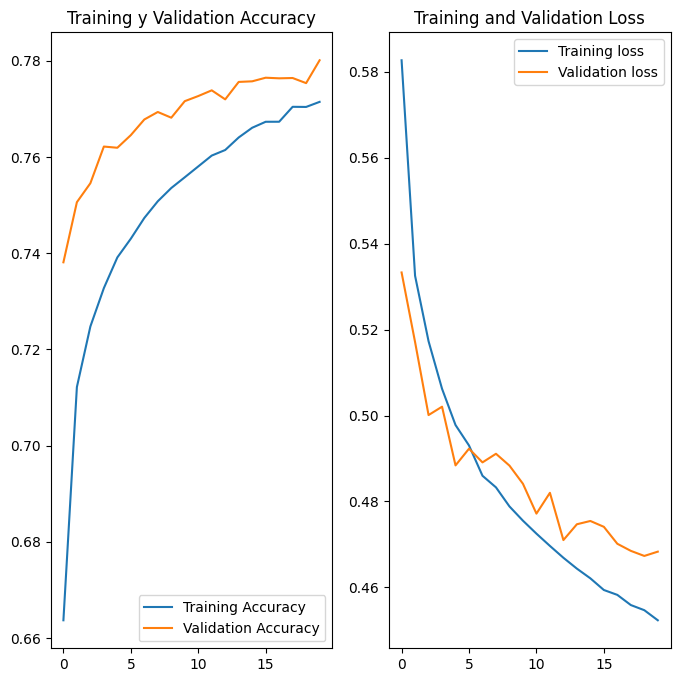

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training y Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
epochs = [*range(20)]
slope, *_ = linregress(epochs, val_loss)
print(f"The slope of your validation loss curve is {slope:.5f}")

The slope of your validation loss curve is -0.00264
